# UTS Proyek Sains Data "Prediksi Produksi Listrik"

*   Nama : Rizqiya Ivada
*   Nim : 220411100090
*   Kelas : Proyek Sains Data (D)





# Data Understanding

Data yang digunakan berdasarkan data yang diperoleh dari website kaggle berupa data produksi listrik, berikut untuk link data yang digunakan: [link kaggle](https:///www.kaggle.com/datasets/shenba/time-series-datasets?resource=download). Dalam data tersebut terdapat 2 fitur yaitu DATE yang menunjukkan tanggal produksi listrik yang diamati, dan juga IPG2211A2N sebagai fitur untuk menunjukkan produksi listrik yang diamati. Dataset ini terdiri dari 397 data yang diamati sejak tahun 1985. Untuk proses pengamatan yang dilakukan yaitu dilakukan per tanggal 1 disetiap bulan pada tahun tersebut.

In [182]:
pip install pandas statsmodels matplotlib

In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Menampilkan data

Sebelum menampilkan data, kita perlu melakukan import library yang akan diperlukan dan digunakan selama melakukan pemrosesan data nantinya.

In [206]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler #new
from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings

Setelah melakukan import library yang diperlukan selanjutnya, code dibawah ini digunakna untuk menampilkan data dlaam file dengan format csv.

In [207]:
df = pd.read_csv('/content/drive/MyDrive/PSD/Electric_Production.csv')
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


# Data PreProcessing

## Deskripsi Dataset

*   **Count** digunakan untuk menunjukkan jumlah data yang ada di dalam dataset
*   **Mean** digunakan untuk menunjukkan nilai rata-rata dari data yang ada
*  **Min dan Max** digunakan untuk menunjukkan nilai minimal dan nilai maksimal dari data-data tersebut.
*   **25%**: Kuartil pertama (Q1) digunakan untuk menunjukkan 25% dari nilai berada di bawah angka yang tertera.
*   **50% (median)**: Median (nilai tengah) digunakan untuk menunjukkan bahwa 50% dari data memiliki nilai lebih kecil dari nilai yang tertera dan 50% lainnya lebih besar.
*   **75%: Kuartil ketiga (Q3)** digunakan untuk menunjukkan 75% dari nilai berada di bawah angka yang tertera.
*   **Std (standar deviasi)** digunakan untuk menunjukkan seberapa tersebar nilai-nilai dalam data dari rata-ratanya. Semakin tinggi standar deviasi, semakin bervariasi atau menyebar data.


In [208]:
description = df.describe()
print(description)

       IPG2211A2N
count  397.000000
mean    88.847218
std     15.387834
min     55.315100
25%     77.105200
50%     89.779500
75%    100.524400
max    129.404800


## Missing Value

Code dibawah ini digunakan untuk mengecek apakah didalam dataset yang digunakan terdapat missing value atau tidak. Setelah di cek menggunakan code dibawah, pada dataset ini tidak memiliki missing value didalamnya.

In [209]:
missing_values = df.isnull().sum()
print(missing_values)

DATE          0
IPG2211A2N    0
dtype: int64


## Mengkonversi format DATE

Code dibawah digunakan untuk mengkonversi format fitur DATE menjadi datetime

In [210]:
# Mengonversi 'transaction_date' ke format datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


# Modelling

## Bagging Regressor

### Membagi Data

Code dibawah ini digunakan untuk membagi data menjadi data train dan juga data test, dimana jumlah data test yang akan digunakan sebanyak 20% dan data train yang akan digunakan sebanyak 80%, data yang lain tidak akan dilakukan pengacakan sebelum pembagian data untuk mempertahankan urutan temporal dari data

In [216]:
# Menyembunyikan semua warning
warnings.filterwarnings("ignore")

# Asumsi DataFrame 'df' sudah diinisialisasi
# Gantilah ini dengan data Anda yang sebenarnya
# df = pd.DataFrame({
#     'DATE': pd.date_range(start='2020-01-01', periods=60, freq='M'),
#     'IPG2211A2N': np.random.rand(60) * 100  # Contoh nilai acak
# })

# Mengatur kolom tanggal sebagai indeks
# df['DATE'] = pd.to_datetime(df['DATE'])  # Pastikan kolom tanggal dalam format datetime
# df.set_index('DATE', inplace=True)

# Menambahkan lagged features
df['lag1'] = df['IPG2211A2N'].shift(1)
df['lag2'] = df['IPG2211A2N'].shift(2)
df['lag3'] = df['IPG2211A2N'].shift(3)

# Drop missing values yang muncul karena lagging
df = df.dropna()

# Menyiapkan data untuk model
X = df[['lag1', 'lag2', 'lag3']]  # Fitur lagged
y = df['IPG2211A2N']  # Target

# Membagi data menjadi train dan test set tanpa shuffle karena data time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Membangun model bagging regressor



*   Code dibawah digunakan untuk membangun model bagging yang akan digunakan yaitu menggunakan decision tree dengan menggunakan estimaor sebanyak 100 dengan random state sebanyak 42
*   Setelah itu dilakukan pelatihan terkait dengan model yang digunakan dengan menggunakan data yang sudah dibagi sebelumnya
*   Setelah itu dilakukan proses prediksi dengan menggunakan data test yang sudah disiapkan sebelumnya
*   Setelah itu dilakukan perhitungan untuk metrik evaluasi untuk mengukur kinerja dan kualitas dari model regresi yang digunakan

In [217]:
# Membuat Bagging Regressor menggunakan DecisionTree sebagai base model
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Melatih Bagging Regressor
bagging_model.fit(X_train, y_train)

# Prediksi menggunakan Bagging Regressor pada data test
y_pred_bagging = bagging_model.predict(X_test)

# Menghitung Mean Squared Error (MSE), RMSE, MAE, dan R^2
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
rmse_bagging = np.sqrt(mse_bagging)
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print(f'Mean Squared Error (MSE) Bagging: {mse_bagging}')
print(f'Root Mean Squared Error (RMSE) Bagging: {rmse_bagging}')
print(f'Mean Absolute Error (MAE) Bagging: {mae_bagging}')
print(f'R-squared (R²) Bagging: {r2_bagging}')


Mean Squared Error (MSE) Bagging: 51.22539638728989
Root Mean Squared Error (RMSE) Bagging: 7.1571919345012605
Mean Absolute Error (MAE) Bagging: 4.989758666666669
R-squared (R²) Bagging: 0.4429815998194505


### Visualisasi bagging

Code dibawah digunakan untuk melakukan prediksi dengan menggunakan sliding windows dan juga menampilkan visualisasi data.

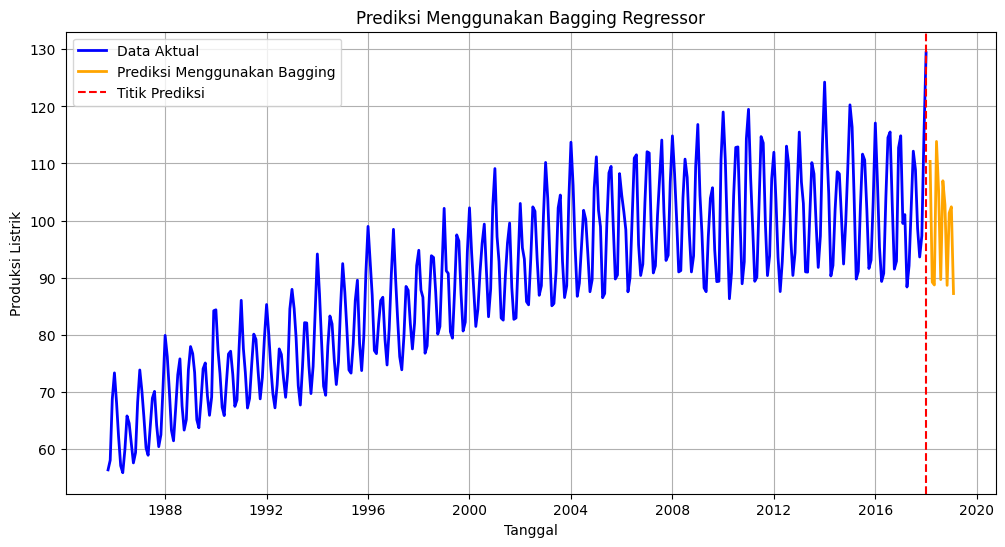

In [222]:
# df['DATE'] = pd.to_datetime(df['DATE'])  # Pastikan kolom tanggal dalam format datetime
# df.set_index('DATE', inplace=True)
# === Prediksi Bagging untuk periode yang akan datang ===
n_future_steps = 12  # Prediksi 12 bulan ke depan
last_window = X.values[-1]  # Ambil window terakhir dari fitur lagged

# Melakukan prediksi dengan menerapkan pendekatan sliding windows
future_predictions = []
for _ in range(n_future_steps):
    last_window_df = pd.DataFrame([last_window], columns=['lag1', 'lag2', 'lag3'])
    next_pred = bagging_model.predict(last_window_df)  # Prediksi langkah berikutnya
    future_predictions.append(next_pred[0])  # Simpan prediksi
    # Update last_window untuk prediksi berikutnya
    last_window = np.roll(last_window, -1)  # Geser window
    last_window[-1] = next_pred[0]  # Masukkan prediksi baru ke dalam window

# Membuat index untuk prediksi di masa depan
future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_future_steps, freq='M')

# Visualisasi hasil prediksi ke depan
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IPG2211A2N'], label='Data Aktual', color='blue', linewidth=2)  # Data aktual
plt.plot(future_index, future_predictions, label='Prediksi Menggunakan Bagging', color='orange', linewidth=2)  # Prediksi
plt.axvline(x=df.index[-1], color='red', linestyle='--', label='Titik Prediksi')  # Garis vertikal untuk batas prediksi
plt.title('Prediksi Menggunakan Bagging Regressor')
plt.xlabel('Tanggal')
plt.ylabel('Produksi Listrik')
plt.legend()
plt.grid()
plt.show()